---
jupyter:
  jupytext:
    text_representation:
      extension: .qmd
      format_name: quarto
      format_version: '1.0'
      jupytext_version: 1.16.4
  kernelspec:
    display_name: Python 3
    language: python
    name: python3
---

In [110]:
import numpy as np 
import tensorflow as tf 
import matplotlib.pyplot as plt
import keras

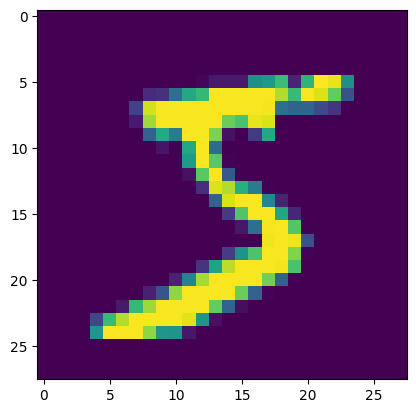

In [111]:
mnist = keras.datasets.mnist
(x_test,y_test), (x_train, y_train) = mnist.load_data()

keras.utils.normalize(x_train, axis=1)
keras.utils.normalize(x_test, axis=1)

keras.utils.to_categorical(y_test, 10)
keras.utils.to_categorical(y_train, 10)

test_data = {'X': x_test, 'Y': y_test}
train_data = {'X': x_train, 'Y': y_train }

plt.imshow(x_test[0])

In [112]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=(28, 28, 1)),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dense(10, activation="softmax"),
])



model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])



model.fit(x_train, y_train, epochs=3)
print(y_train[0])

Epoch 1/3


/Users/mandakausthubh/.pyenv/versions/3.12.5/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6729 - loss: 12.9542
Epoch 2/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8654 - loss: 0.8903
Epoch 3/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9095 - loss: 0.4489
7


In [113]:
new_model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=(28, 28, 1)),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dense(10, activation="softmax"),
])

In [114]:
class PBTTuner:
    
    def __init__(self, model, NumberOfAgents, CutOffMeasure, NumberOfLearningIterations, InitialHyperParameter):
        self.listOfAgents = [keras.models.clone_model(model) for _ in range(NumberOfAgents)]
        self.HyperParameters = InitialHyperParameter
        self.NumberOfAgents = NumberOfAgents
        self.InitialHyperParameter = InitialHyperParameter
        self.NumberOfLearningIterations = NumberOfLearningIterations
        self.CutOffMeasure = CutOffMeasure
        self.Iterations = NumberOfLearningIterations
        for Agent, rate in zip(self.listOfAgents,self.HyperParameters):
            optimizer = keras.optimizers.Adam(learning_rate=rate)
            Agent.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        
    def PBTOptimizeFit(self, train_data, x_data, y_data, numDataPoints = 1000):
        # 1. Calculate the size of the data slices
        sliceSize = int(len(x_data)/numDataPoints)

        # 2. Create a list of indices
        accuracy_val = []
        loss_val = []
        for iter in range(self.NumberOfLearningIterations):
            index = iter % (len(x_data) // sliceSize)
            x = x_data[index * sliceSize:(index + 1) * sliceSize]
            y = y_data[index * sliceSize:(index + 1) * sliceSize]
            for Agent in self.listOfAgents:
                Agent.fit(x, y, epochs=1)
            losses =np.zeros(self.NumberOfAgents)
            for i, Agent in enumerate(self.listOfAgents):
                loss, accuracy = Agent.evaluate(x, y)
                losses[i] = loss
                accuracy_val.append(accuracy)
                loss_val.append(loss)
            bestAgent = np.argmin(losses)
            worstAgents = np.argsort(losses) [self.CutOffMeasure:]
            for i in worstAgents:
                noisyweights = [
                    np.random.normal(0, 0.01, w.shape) + w
                    for w in self.listOfAgents[bestAgent].get_weights()
                ]
                self.HyperParameters[i] = self.HyperParameters[bestAgent]
                self.listOfAgents[i].set_weights(noisyweights)
                optimizer = keras.optimizers.Adam(learning_rate=self.HyperParameters[bestAgent] + np.random.normal(0, 0.000001))
                self.listOfAgents[i].compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

        plt.plot(accuracy_val)
        plt.plot(loss_val)
        
        losses = np.zeros(self.NumberOfAgents)
        for i, Agent in enumerate(self.listOfAgents):
            losses[i] = Agent.evaluate(x_data, y_data)[0]
        bestAgent = np.argmin(losses)
        return self.listOfAgents[bestAgent]


(10000,)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.1000 - loss: 188.7539
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.1000 - loss: 136.0882
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.0000e+00 - loss: 117.4423
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.1000 - loss: 136.0059
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.1000 - loss: 124.7475
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.1000 - loss: 103.0219
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.0000e+00 - loss: 98.1781
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.1000 - loss: 174.0065
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.0000e+00 - loss: 97.9897
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.2000 - loss: 89.0176
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.3000 - loss: 87.2589
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.2000 - loss: 61.0278
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.2000 - loss: 50.0120
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step -

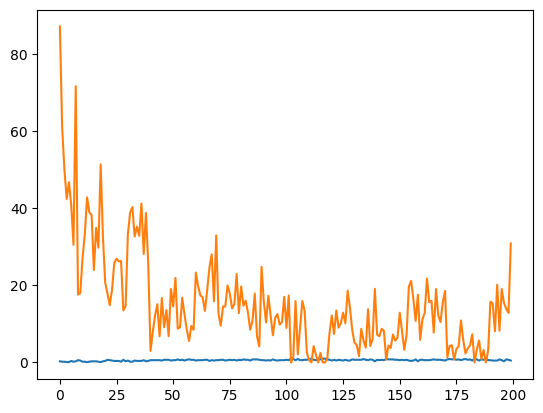

In [115]:
para = [10,1,0.1,0.01,0.001,0.5,100,0.05, 0.0001, 1000]
para = np.array(para).astype(np.float64)
pbtModel = PBTTuner(
    model=new_model,
    NumberOfAgents=len(para), 
    CutOffMeasure=4, 
    NumberOfLearningIterations=20, 
    InitialHyperParameter=para,
)
keras.utils.to_categorical(y_train, 10)
print(y_train.shape)
optimized_model = pbtModel.PBTOptimizeFit(train_data=train_data, x_data=x_train, y_data=y_train)

In [116]:
optimized_model.evaluate(x_test, y_test)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.3793 - loss: 43.5669


[43.35350036621094, 0.3791666626930237]